In [1]:
import projectpath

from importlib import resources
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Tuple, Union

# import escher
import ipywidgets as widgets
import jax
import jax.numpy as jnp
# import bokeh.models
# import bokeh.plotting as plt
import numpy as np
import pandas as pd
# import panel as pn
import scipy

from mosmo.model import Molecule, Reaction, Pathway, ReactionNetwork
from mosmo.knowledge import kb
from mosmo.calc import fba_gd
import mosmo.preso.escher.pw as pw_files

ArrayT = Union[np.ndarray, jnp.ndarray]
jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))  # Gets the No GPU warning out of the way

# plt.output_notebook()

KB = kb.configure_kb()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Glycolysis, Pentose Phosphate, and Entner-Doudoroff

In [2]:
network = ReactionNetwork()
for pw_name in ['glycolysis', 'pentose phosphate', 'entner-doudoroff']:
    pws = KB.find(KB.pathways, pw_name)
    if not pws:
        raise ValueError(f'{pw_name} not found in {KB.pathways}')
    if len(pws) > 1:
        print(f'Multiple hits to "{pw_name}"')
    for pw in pws:
        for step in pw.steps:
            network.add_reaction(step)

# TODO: Decide is it reasonable to track intermediates as part of a pathway definition? Or is that always contextual?
intermediates = [KB(met_id) for met_id in  (
    'Fru.D.6P',
    'Fru.D.bis16',
    'dhap',
    'gap',
    'dpg',
    '3pg',
    '2pg',
    'pep',
    'pyr',
    '6pgdl',
    '6pg',
    'Rib.D.5P',
    'Rul.D.5P',
    'Xul.D.5P',
    'Sed.D.7P',
    'Ery.D.4P',
    'kdpg',
)]
boundaries = [met for met in network.reactants if met not in intermediates]

print(f'Network has {network.shape[0]} reactants ({len(intermediates)} intermediates + {len(boundaries)} boundaries) in {network.shape[1]} reactions')


Network has 31 reactants (17 intermediates + 14 boundaries) in 22 reactions


In [3]:
fba = fba_gd.FbaGd(network, intermediates, {
    'carbon': fba_gd.ProductionObjective(network, {KB.get(KB.compounds, 'accoa'): 2}),
    'redox': fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'pgldh'): 1, KB.get(KB.reactions, 'pgldhat'): 1}),
}, w_fitness=1e6)
fba.solve()  # Forces jit

%timeit fba.solve()

8.45 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
fba.solve()

FbaResult(v0=array([-1.21168806, -1.93155138,  0.76493161, -0.48785867, -1.12938319,
       -1.03128852, -0.6617512 ,  0.50920547, -0.88039454, -0.52909024,
       -0.39837618, -1.54922766, -1.4355266 , -0.09371368, -0.39145972,
       -0.66105236, -1.82118187,  1.19629401, -0.6544781 , -0.19953856,
       -0.88358456, -0.59103877]), velocities=array([-8.33333333e-01, -1.33226763e-15,  1.66666667e-01, -1.66666667e-01,
        1.66666667e-01,  1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        1.00000000e+00, -1.00000000e+00,  2.84494650e-16,  2.00000000e+00,
       -3.33333333e-01, -3.33333333e-01,  6.66666667e-01,  2.00000000e+00,
        1.00000000e+00,  3.33333333e-01,  3.33333333e-01,  2.00000000e+00,
        1.00000000e+00,  1.00000000e+00]), dmdt=array([-1.16666667e+00,  2.22044605e-16,  2.00000000e+00, -2.00000000e+00,
        9.43689571e-16,  4.00000000e+00, -1.66666667e-01, -8.33333333e-01,
        6.66133815e-16,  2.77555756e-17, -3.00000000e+00,  2.88657986e-15,
     

## Interface stuff

In [5]:
pgi = KB('pgi')
pgldh = KB('pgldh')
pgldhat = KB('pgldhat')
pfk = KB('pfk')
fbp = KB('fbp')
pyk = KB('pyk')
pps = KB('pps')

fba_kinetic = fba_gd.FbaGd(network, intermediates, {
    'fluxes': fba_gd.VelocityObjective(network, {pgi: 2, pgldh: 0, pgldhat: 0}),
    'futile1': fba_gd.ExclusionObjective(network, [pfk, fbp]),
    'futile2': fba_gd.ExclusionObjective(network, [pyk, pps]),
})
fba_soln = fba_kinetic.solve()

# diag = escher.Builder(
#     width=600,
#     height=600,
#     map_json=resources.read_text(pw_files, 'glycolysis_ppp_ed.json'),
#     # map_json=resources.read_text(files.pw, 'central_carbon.json'),
#     menu='zoom',
#     enable_editing=False,
#     never_ask_before_quit=True,
#     reaction_data={r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)},
#     reaction_styles = ['abs', 'color', 'size',],
#     reaction_scale = [
#         {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
#         {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
#     ],
# )

# bflux_plot = plt.figure(
#     title = 'Boundary Flux',
#     width = 300,
#     height = 200,
#     tools=[],
#     x_range=[boundary.label for boundary in boundaries],
#     y_range=(-10, 10),
# )
# bflux_plot.xaxis.major_label_orientation = np.pi/4
# bflux_data = bokeh.models.ColumnDataSource({'met': network.reactants.labels(), 'dmdt': fba_soln.dmdt})
# bflux_view = bokeh.models.CDSView(
#     source=bflux_data,
#     filters=[bokeh.models.IndexFilter([network.reactants.index_of(b) for b in boundaries])]
# )
# bars = bflux_plot.vbar(
#     source = bflux_data,
#     view = bflux_view,
#     x = 'met',
#     top = 'dmdt',
#     width=0.5,
#     color='#1f77b4',
# )

# target_pgi = widgets.FloatSlider(
#     value=2,
#     min=0,
#     max=5.0,
#     step=0.1,
#     description='Glycolysis',
#     continuous_update=False,
#     readout=True,
#     readout_format='.1f',
# )
# target_pgldh = widgets.FloatSlider(
#     value=0,
#     min=0,
#     max=5.0,
#     step=0.1,
#     description='PPP',
#     continuous_update=False,
#     readout=True,
#     readout_format='.1f',
# )
# target_pgldhat = widgets.FloatSlider(
#     value=0,
#     min=0,
#     max=5.0,
#     step=0.1,
#     description='ED',
#     continuous_update=False,
#     readout=True,
#     readout_format='.1f',
# )

# def update_fba_kinetic(change):
#     fba_kinetic.update_params({'fluxes': {pgi: target_pgi.value, pgldh: target_pgldh.value, pgldhat: target_pgldhat.value}})
#     fba_soln = fba_kinetic.solve()
#     diag.reaction_data = {r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)}
#     bflux_data.data['dmdt'] = fba_soln.dmdt

# target_pgi.observe(update_fba_kinetic, names='value')
# target_pgldh.observe(update_fba_kinetic, names='value')
# target_pgldhat.observe(update_fba_kinetic, names='value')

# dashboard = widgets.HBox(
#     [widgets.VBox([diag], layout = widgets.Layout(width='60%', height='100%')),
#      widgets.VBox([
#          target_pgi,
#          target_pgldh,
#          target_pgldhat,
#          pn.ipywidget(bflux_plot)
#      ], layout = widgets.Layout(width='40%', height='100%'))],
#     layout = widgets.Layout(width='900px', height='600px', border='1px solid green')
# )
# dashboard

In [6]:
acCoA = KB('accoa')
atp = KB('atp')
nadph = KB('nadp.red')

pfk = KB('pfk')
fbp = KB('fbp')
pyk = KB('pyk')
pps = KB('pps')

fba_mets = fba_gd.FbaGd(network, intermediates, {
    'mets': fba_gd.ProductionObjective(network, {acCoA: 2, atp: 3, nadph: 0}),
    'futile1': fba_gd.ExclusionObjective(network, [pfk, fbp]),
    'futile2': fba_gd.ExclusionObjective(network, [pyk, pps]),
})
fba_soln = fba_mets.solve()

# diag = escher.Builder(
#     width=600,
#     height=600,
#     map_json=resources.read_text(pw_files, 'glycolysis_ppp_ed.json'),
#     # map_json=resources.read_text(files.pw, 'central_carbon.json'),
#     menu='zoom',
#     enable_editing=False,
#     never_ask_before_quit=True,
#     reaction_data={r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)},
#     reaction_styles = ['abs', 'color', 'size',],
#     reaction_scale = [
#         {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
#         {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
#     ],
# )

# bflux_plot = plt.figure(
#     title = 'Boundary Flux',
#     width = 300,
#     height = 200,
#     tools=[],
#     x_range=[boundary.label for boundary in boundaries],
#     y_range=(-10, 10),
# )
# bflux_plot.xaxis.major_label_orientation = np.pi/4
# bflux_data = bokeh.models.ColumnDataSource({'met': network.reactants.labels(), 'dmdt': fba_soln.dmdt})
# bflux_view = bokeh.models.CDSView(
#     source=bflux_data,
#     filters=[bokeh.models.IndexFilter([network.reactants.index_of(b) for b in boundaries])]
# )
# bars = bflux_plot.vbar(
#     source = bflux_data,
#     view = bflux_view,
#     x = 'met',
#     top = 'dmdt',
#     width=0.5,
#     color='#1f77b4',
# )

# target_accoa = widgets.FloatSlider(
#     value=2,
#     min=0,
#     max=5.0,
#     step=0.1,
#     description='acCoA',
#     continuous_update=False,
#     readout=True,
#     readout_format='.1f',
# )
# target_atp = widgets.FloatSlider(
#     value=3,
#     min=0,
#     max=5.0,
#     step=0.1,
#     description='ATP',
#     continuous_update=False,
#     readout=True,
#     readout_format='.1f',
# )
# target_nadph = widgets.FloatSlider(
#     value=0,
#     min=0,
#     max=5.0,
#     step=0.1,
#     description='NADPH',
#     continuous_update=False,
#     readout=True,
#     readout_format='.1f',
# )

# def update_fba_mets(change):
#     fba_mets.update_params({'mets': {acCoA: target_accoa.value, atp: target_atp.value, nadph: target_nadph.value}})
#     fba_soln = fba_mets.solve()
#     diag.reaction_data = {r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)}
#     bflux_data.data['dmdt'] = fba_soln.dmdt

# target_accoa.observe(update_fba_mets, names='value')
# target_atp.observe(update_fba_mets, names='value')
# target_nadph.observe(update_fba_mets, names='value')

# dashboard = widgets.HBox(
#     [widgets.VBox([diag], layout = widgets.Layout(width='60%', height='100%')),
#      widgets.VBox([
#          target_accoa,
#          target_atp,
#          target_nadph,
#          pn.ipywidget(bflux_plot)
#      ], layout = widgets.Layout(width='40%', height='100%'))],
#     layout = widgets.Layout(width='900px', height='600px', border='1px solid green')
# )
# dashboard

## Solution variability

**NOTE** Before updates to FbaGd in revision [70baa3605369ec4035a9c87f8834e1a53a3ac678](https://github.com/fdrusso/msmtk/commit/70baa3605369ec4035a9c87f8834e1a53a3ac678) ('Revert to least_squares() instead of minimize()...'), this section showed modest but real variability between solutions from different v0 starting points. After that revision the variability is insignificiant.

In [7]:
%%time
results = [fba_kinetic.solve(v0=v0) for v0 in jax.random.uniform(prng, (100, network.shape[1]))]

CPU times: user 823 ms, sys: 5.23 ms, total: 828 ms
Wall time: 822 ms


In [8]:
velocity_df = pd.DataFrame([soln.velocities for soln in results], columns=network.reactions.labels())
velocity_df.head()

,PGI,PFK,FBP,FBA,TPI,GAPDH,PGK,GPMM,ENO,PYK,...,R5PI,TKT1,RPE,PGLase,PGLDH,TALA,TKT2,G6PDH,KDPGA,PGLDhat
0,2.0,2.0,2.165695e-24,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,8.355615e-25,-1.906393e-25,2.080876e-24,-3.541367e-24,-3.425045e-25,-5.751490e-25,2.740036e-24,1.085675e-24,2.662488e-24,-5.040632e-25
1,2.0,2.0,1.735360e-09,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,-5.865703e-20,8.131516e-20,-4.209754e-19,-2.871442e-19,-1.600892e-19,-3.570244e-19,-5.027141e-19,-2.973086e-19,-2.117582e-19,-1.541600e-19
2,2.0,2.0,3.932727e-17,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,-2.171349e-24,9.499652e-25,1.021051e-24,2.481542e-24,4.627042e-24,-5.764415e-24,-3.127777e-24,6.410650e-24,5.583469e-24,1.654361e-24
3,2.0,2.0,1.324309e-10,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,4.182225e-21,2.421985e-21,6.114519e-21,-5.293956e-21,-6.140989e-21,-4.764560e-22,7.623297e-21,1.270549e-21,-6.776264e-21,-2.435220e-21
4,2.0,2.0,-7.998153e-18,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,7.084802e-22,-1.670905e-22,-8.205632e-22,2.388898e-21,-5.360130e-22,1.621274e-21,-6.815968e-22,-2.071260e-21,-3.275635e-21,1.158053e-21


In [9]:
dmdt_df = pd.DataFrame([soln.dmdt for soln in results], columns=network.reactants.labels())
dmdt_df.head()

,G6P,F6P,ATP,ADP,F16bP,H+,H2O,Pi,GAP,DHAP,...,R5P,Ru5P,Sed7P,Xu5P,6PGDL,6PG,NADP+,NADPH,E4P,KDPG
0,-2.0,0.000000e+00,6.0,-6.0,-2.165695e-24,2.0,4.0,-4.0,2.662488e-24,0.0,...,-1.026201e-24,-1.587819e-24,7.657883e-25,-8.497988e-25,4.627042e-24,-2.694799e-24,-7.431701e-25,7.431701e-25,-3.315185e-24,-3.166551e-24
1,-2.0,0.000000e+00,6.0,-6.0,7.988537e-17,2.0,4.0,-4.0,-2.117582e-19,0.0,...,1.399722e-19,2.022291e-19,2.757092e-19,1.630538e-19,-1.016440e-20,2.710505e-20,4.573978e-19,-4.573978e-19,1.456897e-19,5.759824e-20
2,-2.0,0.000000e+00,6.0,-6.0,-3.932727e-17,2.0,4.0,-4.0,5.583469e-24,0.0,...,3.121314e-24,1.434641e-24,4.814450e-24,5.098793e-24,3.929108e-24,-3.799861e-24,-1.103769e-23,1.103769e-23,-2.636638e-24,-3.929108e-24
3,-2.0,0.000000e+00,6.0,-6.0,2.356784e-17,2.0,4.0,-4.0,-6.776264e-21,0.0,...,-1.760240e-21,-8.073283e-21,-1.945529e-21,9.132074e-22,6.564505e-21,3.282253e-21,4.870439e-21,-4.870439e-21,-8.099753e-21,4.341044e-21
4,-2.0,2.220446e-16,6.0,-6.0,7.998153e-18,2.0,4.0,-4.0,-3.275635e-21,0.0,...,-8.755707e-22,9.930303e-22,-1.454184e-21,-3.060568e-22,-4.460158e-21,1.766858e-21,2.607273e-21,-2.607273e-21,2.302871e-21,4.433688e-21


<Axes: >

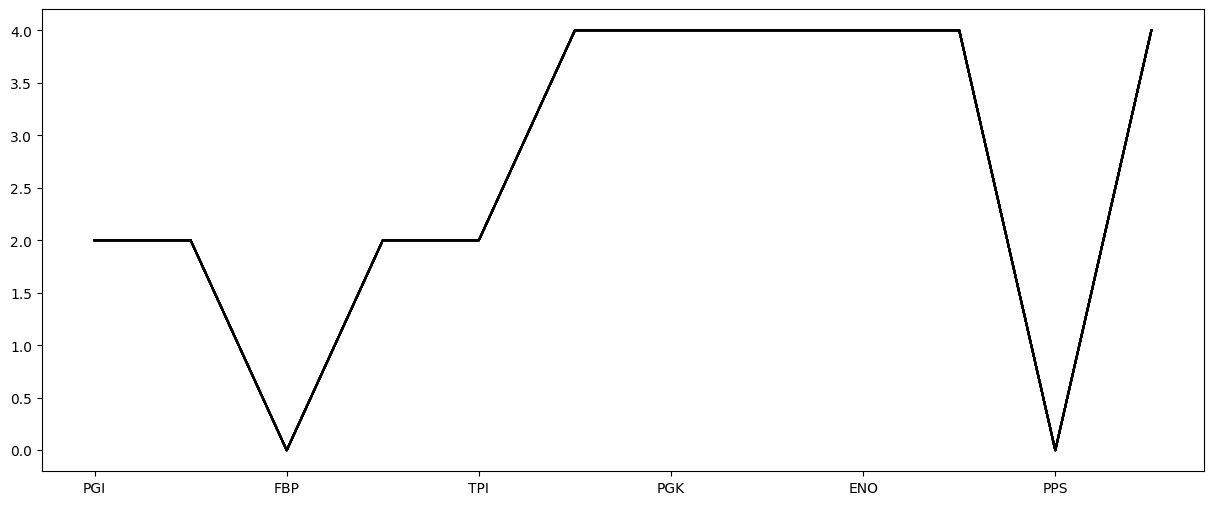

In [10]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
velocity_df.abs()[[step.label for step in glycolysis.steps]].T.plot(color='#0001', legend=False, figsize=(15,6))

<Axes: >

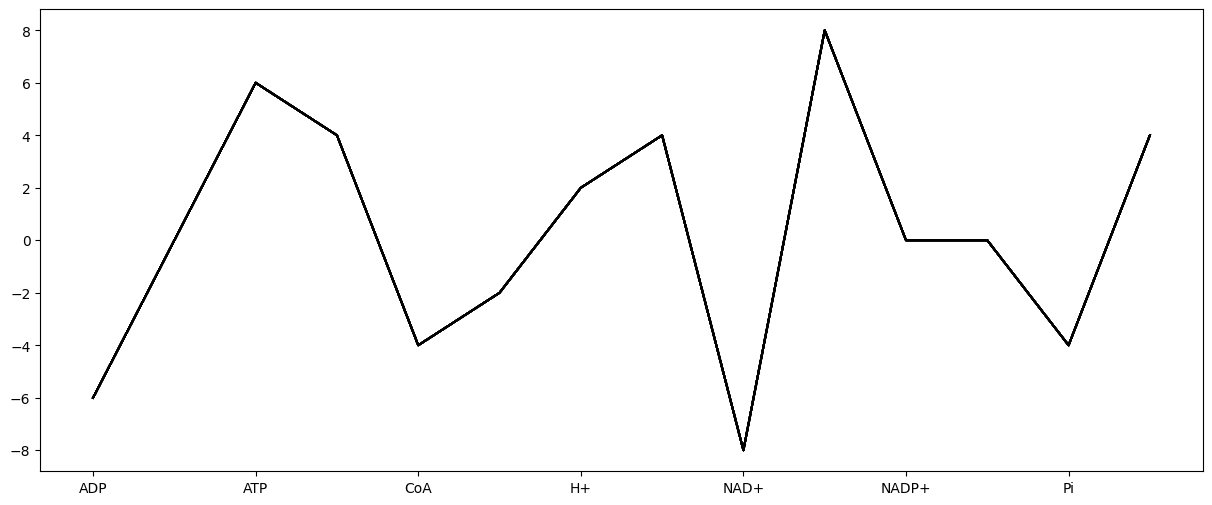

In [11]:
dmdt_df[(sorted(boundary.label for boundary in boundaries))].T.plot(color='#0001', legend=False, figsize=(15,6))

In [12]:
%%time
results = []
for v0s in jax.random.uniform(prng, (100, 21, network.shape[1])):
    v0_ = v0_ = np.median([fba_kinetic.solve(v0=v0).velocities for v0 in v0s], axis=0)
    results.append((fba_kinetic.solve(v0=v0_)))


CPU times: user 6.84 s, sys: 9.36 ms, total: 6.85 s
Wall time: 6.85 s


<Axes: >

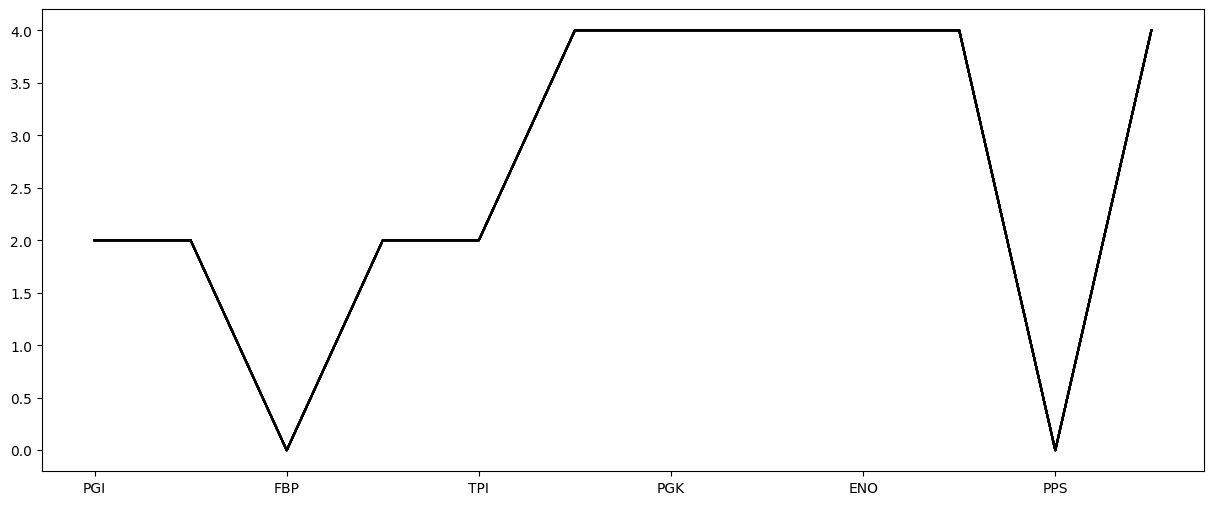

In [13]:
pd.DataFrame([soln.velocities for soln in results], columns=network.reactions.labels()).abs()[[step.label for step in glycolysis.steps]].T.plot(color='#0001', legend=False, figsize=(15,6))

<Axes: >

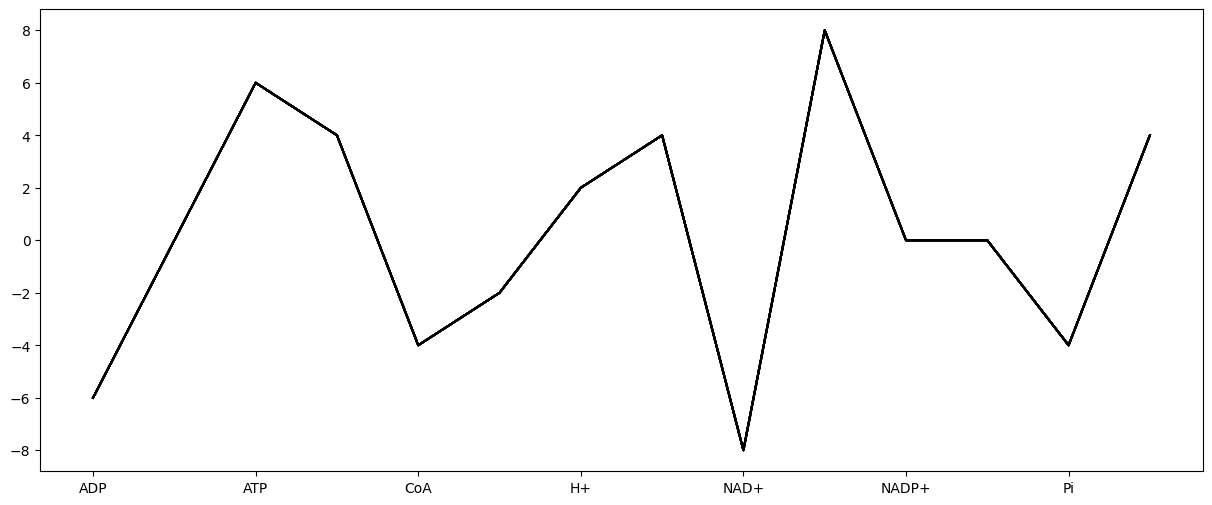

In [14]:
pd.DataFrame([soln.dmdt for soln in results], columns=network.reactants.labels())[sorted(boundary.label for boundary in boundaries)].T.plot(color='#0001', legend=False, figsize=(15,6))